📂 成功加载数据: mcm26Train-B-Data/hall_calls.csv

🎲 [图1] 单日详情分析: 2025-11-30 (周末)


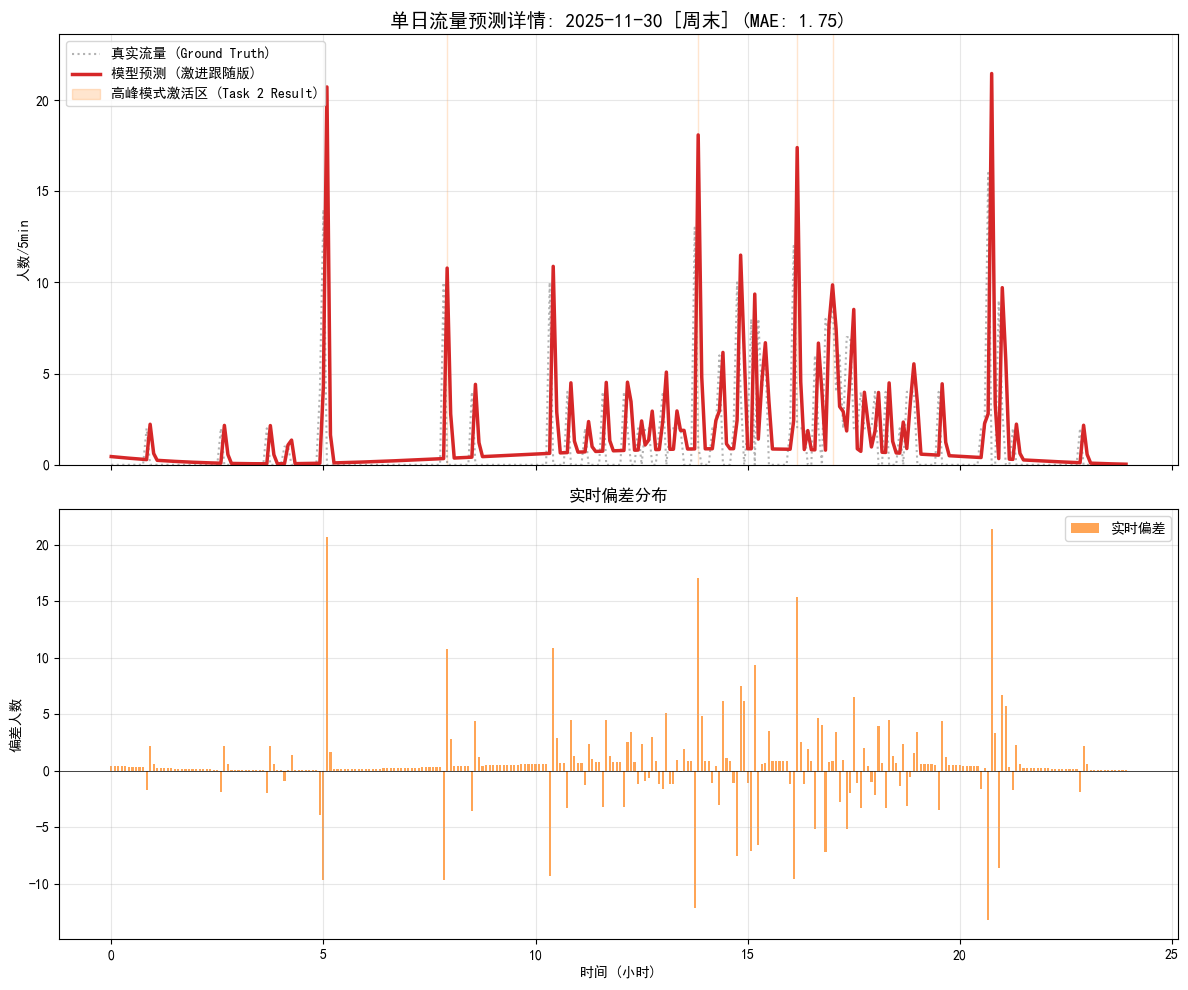


📊 [图2] 全月趋势分析正在进行...
✅ 月度平均误差 (Overall MAE): 6.70


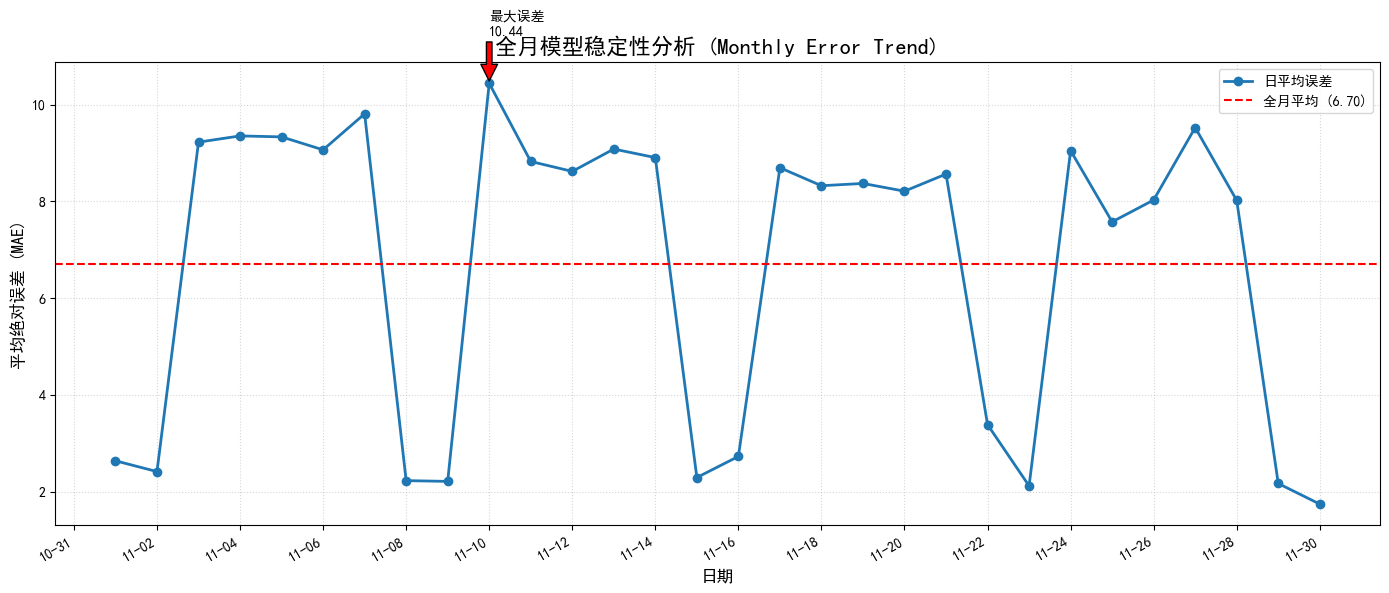

In [44]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import warnings
import os

# 忽略警告
warnings.filterwarnings('ignore')

# 设置中文字体 (兼容不同系统)
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 🔮 模块一：Task 1 趋势感知预测器 (激进跟随时版)
# ==========================================
class DemandPredictor:
    def __init__(self, raw_data):
        self.raw_data = raw_data
        self.weekday_model = None
        self.weekend_model = None
        # 训练分别针对工作日和周末的模型
        self._train_history_models()

    def _train_history_models(self):
        """分别训练 工作日 和 周末 的宏观模型"""
        df = self.raw_data.copy()
        df['Time'] = pd.to_datetime(df['Time'])
        df['DayOfWeek'] = df['Time'].dt.dayofweek 
        
        weekday_df = df[df['DayOfWeek'] < 5]  # 周一到周五
        weekend_df = df[df['DayOfWeek'] >= 5] # 周六周日
        
        self.weekday_model = self._fit_poly(weekday_df)
        self.weekend_model = self._fit_poly(weekend_df)

    def _fit_poly(self, df):
        """拟合多项式曲线"""
        if len(df) == 0: return lambda x: 0
        traffic = df.set_index('Time').resample('5min').size().reset_index()
        traffic.columns = ['Time', 'Count']
        traffic['minutes'] = traffic['Time'].dt.hour * 60 + traffic['Time'].dt.minute
        x = traffic['minutes'].values
        y = traffic['Count'].values
        
        # 6阶多项式拟合，捕捉双峰
        if len(x) > 10:
            coeffs = np.polyfit(x, y, deg=6)
            return np.poly1d(coeffs)
        else:
            return lambda x: 0

    def get_realtime_trend_data(self, current_seconds, day_specific_lookup, is_weekend, window=15):
        """
        🔥 核心升级：包含'激进跟随'逻辑，解决峰值滞后问题
        """
        current_minutes = (current_seconds // 60) % 1440
        x_local = []
        y_local = []
        
        # 1. 获取微观实时数据
        for m in range(current_minutes - window, current_minutes, 5):
            val = day_specific_lookup.get(m, 0)
            x_local.append(m)
            y_local.append(val)
            
        if len(x_local) < 2: return 0, 0 

        # 2. 计算实时趋势 (Slope)
        coeffs = np.polyfit(x_local, y_local, deg=1)
        slope = coeffs[0] 
        func = np.poly1d(coeffs)
        pred_realtime = max(0, func(current_minutes))
        
        # 3. 获取历史基准 (History)
        if is_weekend:
            pred_history = max(0, self.weekend_model(current_minutes))
        else:
            pred_history = max(0, self.weekday_model(current_minutes))
        
        # =======================================================
        # 🔥 关键修改：动态权重分配 (Dynamic Aggressive Weighting)
        # =======================================================
        
        # 基础权重：历史占6成，实时占4成 (稳健模式)
        alpha = 0.4 
        
        # 策略A: 向上突破 (如果实时值 > 历史均值，说明今天很忙，立即跟随)
        if pred_realtime > pred_history:
            alpha = 0.8  # 权重直接给到 80% 给实时
            
        # 策略B: 冲锋补偿 (如果斜率很大，说明正在爬坡，给予额外增益)
        if slope > 1.2:
            pred_realtime *= 1.15   # 预测值额外上浮 15%
            alpha = max(alpha, 0.9) # 权重拉满
            
        # 融合计算
        final_pred = (1 - alpha) * pred_history + alpha * pred_realtime
        
        return final_pred, slope

# ==========================================
# 🧠 模块二：Task 2 智能模式选择器 (完整版)
# ==========================================
class ModeSelector:
    def __init__(self, raw_data):
        self.raw_data = raw_data
        self.valid_windows = {
            'UP_PEAK': (6, 10),   # 06:00 - 10:00
            'LUNCH': (11, 14),    # 11:00 - 14:00
            'DOWN_PEAK': (16, 20) # 16:00 - 20:00
        }
        self.thresholds = {}
        # 自动学习历史数据的繁忙线
        self._learn_activation_thresholds()

    def _learn_activation_thresholds(self):
        """基于历史数据自动计算阈值"""
        temp = self.raw_data.copy()
        temp['Time'] = pd.to_datetime(temp['Time'])
        traffic = temp.set_index('Time').resample('5min').size()
        
        if len(traffic) > 0:
            # 55%分位数作为基准线
            base_line = traffic.quantile(0.55)
            # 40%分位数作为警戒线
            alert_line = traffic.quantile(0.40)
        else:
            base_line = 10
            alert_line = 5
            
        self.thresholds['HARD_TRIGGER'] = max(8, base_line)   # 硬触发
        self.thresholds['SOFT_TRIGGER'] = max(5, alert_line)  # 软触发
        self.thresholds['TREND_SLOPE'] = 1.5                  # 斜率阈值
        # print(f"✅ Task 2 阈值学习完成: 硬触发={self.thresholds['HARD_TRIGGER']:.1f}, 软触发={self.thresholds['SOFT_TRIGGER']:.1f}")

    def get_mode(self, current_seconds, pred_demand, trend_slope):
        """实时判断当前模式"""
        hour = (current_seconds // 3600) % 24
        
        # 1. 筛选时间窗口
        possible_mode = 'OFF_PEAK'
        for mode, (start, end) in self.valid_windows.items():
            if start <= hour < end:
                possible_mode = mode
                break
        
        if possible_mode == 'OFF_PEAK': return 'OFF_PEAK'

        # 2. 双轨触发判断
        # 轨道A: 人数绝对值够大
        if pred_demand >= self.thresholds['HARD_TRIGGER']:
            return possible_mode
            
        # 轨道B: 人数还行，但增长极快 (趋势补偿)
        elif (pred_demand >= self.thresholds['SOFT_TRIGGER']) and (trend_slope >= self.thresholds['TREND_SLOPE']):
            return possible_mode
            
        return 'OFF_PEAK'

# ==========================================
# 🎮 仿真总控中心 (集成画图)
# ==========================================
class SimulationController:
    def __init__(self, data_path):
        try:
            self.full_df = pd.read_csv(data_path)
        except:
            self.full_df = pd.read_csv(data_path, encoding='gbk')
        self.full_df['Time'] = pd.to_datetime(self.full_df['Time'])
        
        # 初始化模块
        self.predictor = DemandPredictor(self.full_df)
        self.mode_selector = ModeSelector(self.full_df)
        
    def run_random_day_simulation(self):
        """📊 功能1: 随机抽取一天，画详细对比图 (含Mode可视化)"""
        unique_dates = self.full_df['Time'].dt.date.unique()
        if len(unique_dates) == 0:
            print("❌ 数据集为空")
            return

        selected_date = random.choice(unique_dates)
        
        # 判断是否周末
        pd_date = pd.to_datetime(selected_date)
        is_weekend = pd_date.dayofweek >= 5
        day_type = "周末" if is_weekend else "工作日"
        
        print(f"\n🎲 [图1] 单日详情分析: {selected_date} ({day_type})")
        
        # 准备该日数据
        day_df = self.full_df[self.full_df['Time'].dt.date == selected_date].copy()
        day_lookup = day_df.set_index('Time').resample('5min').size()
        day_lookup_dict = { (t.hour * 60 + t.minute): count for t, count in day_lookup.items() }
        
        time_axis = []
        actual_curve = []
        pred_curve = []
        errors = []
        mode_flags = [] # 用于画背景颜色
        
        # 模拟 24 小时
        for t_min in range(0, 1440, 5): 
            t_seconds = t_min * 60
            
            # 1. 预测
            pred_val, slope = self.predictor.get_realtime_trend_data(t_seconds, day_lookup_dict, is_weekend)
            
            # 2. 模式识别
            mode = self.mode_selector.get_mode(t_seconds, pred_val, slope)
            
            # 3. 获取真实值
            actual_val = day_lookup_dict.get(t_min, 0)
            
            time_axis.append(t_min / 60.0)
            actual_curve.append(actual_val)
            pred_curve.append(pred_val)
            errors.append(pred_val - actual_val)
            
            # 标记模式状态 (1=激活, 0=休眠)
            is_active = 1 if mode != 'OFF_PEAK' else 0
            mode_flags.append(is_active)

        mae = np.mean(np.abs(errors))
        self._plot_day_detail(selected_date, time_axis, actual_curve, pred_curve, errors, mae, day_type, mode_flags)

    def run_full_month_evaluation(self):
        """📊 功能2: 跑全月数据，画误差趋势图"""
        print("\n📊 [图2] 全月趋势分析正在进行...")
        
        unique_dates = sorted(self.full_df['Time'].dt.date.unique())
        date_list = []
        mae_list = []
        
        for date in unique_dates:
            pd_date = pd.to_datetime(date)
            is_weekend = pd_date.dayofweek >= 5
            
            day_df = self.full_df[self.full_df['Time'].dt.date == date]
            day_lookup = day_df.set_index('Time').resample('5min').size()
            day_lookup_dict = { (t.hour * 60 + t.minute): count for t, count in day_lookup.items() }
            
            daily_errors = []
            for t_min in range(0, 1440, 5):
                t_seconds = t_min * 60
                pred_val, _ = self.predictor.get_realtime_trend_data(t_seconds, day_lookup_dict, is_weekend)
                actual_val = day_lookup_dict.get(t_min, 0)
                daily_errors.append(abs(pred_val - actual_val))
            
            daily_mae = np.mean(daily_errors)
            date_list.append(date)
            mae_list.append(daily_mae)
            
        avg_mae = np.mean(mae_list)
        print(f"✅ 月度平均误差 (Overall MAE): {avg_mae:.2f}")
        self._plot_monthly_trend(date_list, mae_list, avg_mae)

    # --- 绘图函数区 ---
    
    def _plot_day_detail(self, date, x, y_actual, y_pred, errors, mae, day_type, modes):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        
        # 上图：流量对比
        ax1.plot(x, y_actual, label='真实流量 (Ground Truth)', color='gray', linestyle=':', alpha=0.6)
        # 红色加粗实线，代表我们的预测
        ax1.plot(x, y_pred, label='模型预测 (激进跟随版)', color='#d62728', linewidth=2.5) 
        
        # 🔥🔥🔥 核心可视化：Task 2 模式激活区 🔥🔥🔥
        # 用橙色填充背景，显示 Task 2 何时处于激活状态
        ax1.fill_between(x, 0, max(max(y_actual), max(y_pred))*1.2, where=modes, color='#ff7f0e', alpha=0.2, label='高峰模式激活区 (Task 2 Result)')
        
        ax1.set_title(f'单日流量预测详情: {date} [{day_type}] (MAE: {mae:.2f})', fontsize=14)
        ax1.set_ylabel('人数/5min')
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(0, max(max(y_actual), max(y_pred)) * 1.1)
        
        # 下图：实时偏差
        ax2.bar(x, errors, color='#ff7f0e', alpha=0.7, width=0.05, label='实时偏差')
        ax2.axhline(0, color='black', linewidth=0.5)
        ax2.set_title('实时偏差分布', fontsize=12)
        ax2.set_xlabel('时间 (小时)')
        ax2.set_ylabel('偏差人数')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    def _plot_monthly_trend(self, dates, maes, avg_line):
        plt.figure(figsize=(14, 6))
        plt.plot(dates, maes, marker='o', linestyle='-', color='#1f77b4', linewidth=2, label='日平均误差')
        plt.axhline(y=avg_line, color='red', linestyle='--', label=f'全月平均 ({avg_line:.2f})')
        
        # 标注最大误差
        max_idx = np.argmax(maes)
        plt.annotate(f'最大误差\n{maes[max_idx]:.2f}', 
                     xy=(dates[max_idx], maes[max_idx]), 
                     xytext=(dates[max_idx], maes[max_idx]+1),
                     arrowprops=dict(facecolor='red', shrink=0.05))
        
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))
        plt.gcf().autofmt_xdate()
        
        plt.title('全月模型稳定性分析 (Monthly Error Trend)', fontsize=16)
        plt.xlabel('日期', fontsize=12)
        plt.ylabel('平均绝对误差 (MAE)', fontsize=12)
        plt.grid(True, linestyle=':', alpha=0.5)
        plt.legend()
        plt.tight_layout()
        plt.show()

# ==========================================
# ▶️ 执行区域
# ==========================================
if __name__ == "__main__":
    # 自动定位文件路径
    possible_paths = [
        r'mcm26Train-B-Data/hall_calls.csv',
        r'MCM2026/mcm26Train-B-Data/hall_calls.csv',
        r'hall_calls.csv'
    ]
    
    data_path = None
    for p in possible_paths:
        if os.path.exists(p):
            data_path = p
            break
            
    if data_path:
        print(f"📂 成功加载数据: {data_path}")
        sim = SimulationController(data_path)
        
        # 1. 单日验证 (如果随机到周末看不出效果，多运行几次直到随机到工作日)
        sim.run_random_day_simulation()
        
        # 2. 全月评估
        sim.run_full_month_evaluation()
    else:
        print("❌ 找不到文件 hall_calls.csv，请检查路径！")